In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = False
EPS = 120
LAG = 12 + 1
# SROUTE = [
#     '403259-401851', 
#     '401851-401852'
# ]
SROUTE = [
    '400860-400861', 
#     '400861-403781',
#     '400861-400948',
#     '400861-405376',
]
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Full history
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (train): 72


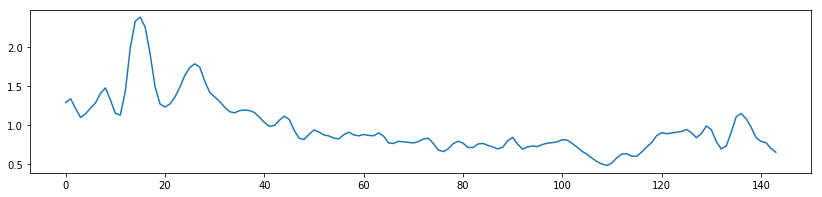

In [4]:
dset = SpotHistory(SROUTE, 'train', 16, lag=None, res=10, smooth=1.0, shuffle=False)

plt.figure(figsize=(14, 3))
for ii in range(len(SROUTE)):
    plt.plot(dset[0][:, ii])
plt.show(); plt.close()

In [5]:
dset = SpotHistory(SROUTE, 'train', 16, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 16, lag=LAG, res=10).generator()

Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (train): 11749
Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (test): 11749


In [6]:
from models.Linear import *
# lag = 6th timestep is predicted based on past 5 (50 mins
if DENSE:
    model = Dense(lag=LAG-1, stops=STOPS).to(device)
else:
    model = Linear(lag=LAG-1, stops=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.001)
evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())

Eval loss: 210.24689    


In [7]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(
            evalset, model, 
            crit=lambda y, _y: criterion(y[:, 0], _y[:, 0]).item(), result=True))
    sys.stdout.flush()
    sch.step()

[1/120 : 735/735] - L4.44       
Eval loss: 3.36825     
[2/120 : 735/735] - L0.85       
Eval loss: 2.99426     
[3/120 : 735/735] - L0.96       
Eval loss: 2.69514     
[4/120 : 735/735] - L3.52       
Eval loss: 2.44802     
[5/120 : 735/735] - L0.92       
Eval loss: 2.23520     
[6/120 : 735/735] - L3.13       
Eval loss: 2.06032     
[7/120 : 735/735] - L0.36       
Eval loss: 1.91301     
[8/120 : 735/735] - L2.35       
Eval loss: 1.78939     
[9/120 : 735/735] - L1.83       
Eval loss: 1.67645     
[10/120 : 735/735] - L0.31       
Eval loss: 1.57950    
[11/120 : 735/735] - L0.52       
Eval loss: 1.49736     
[12/120 : 735/735] - L9.69       
Eval loss: 1.41872    
[13/120 : 735/735] - L0.73      
Eval loss: 1.364464    
[14/120 : 735/735] - L0.54       
Eval loss: 1.29155    
[15/120 : 735/735] - L0.58      
Eval loss: 1.23842    
[16/120 : 735/735] - L0.40      
Eval loss: 1.18593    
[17/120 : 735/735] - L1.24      
Eval loss: 1.14150    
[18/120 : 735/735] - L2.66      


Eval segments: 18
Eval MSE: 2.9706


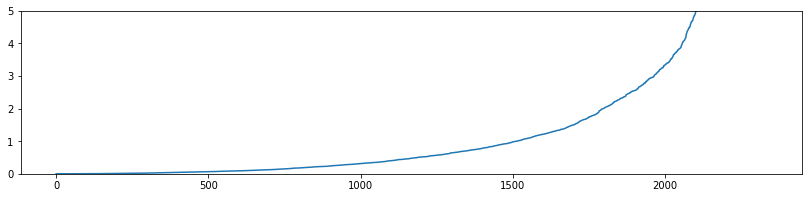

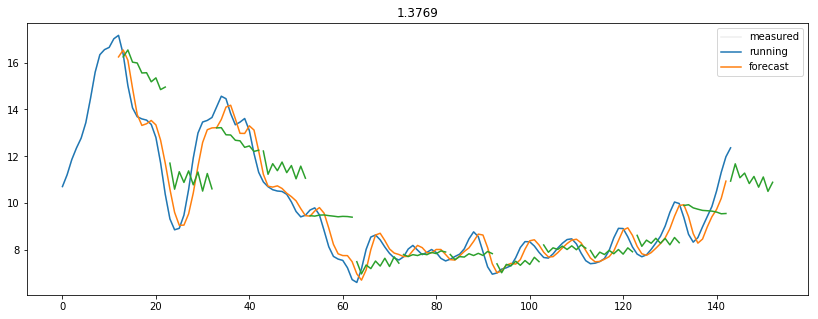

In [8]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 16, lag=None, res=10, shuffle=False, verbose=False)
mses = []

sqerr = eval_lin(viewset, model, test_lag=LAG-1, fmax=10, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

_ = eval_lin(viewset[:1], model, test_lag=LAG-1, fmax=10, plot=True)